## Drone Assisted Emergency Medical Response

***This case uses synthetic data throughout.***

To simplify things a bit, let's say the region we care about (Ontario) is a square with coordinates going from $[0, 1]$.  We divy up the square into $49$ zones, and we assume the time to get to a cardiac event is essentially the same as the time to get to the zone center.  There are 11 potential depot locations.  We have data on the number of cardiac arrest events at different zone centers over the past year, and, from our data science team, their best estimate of the rate of incidents per per year for each zone.  

The cell below loads up this data and makes a small plot to give you a sense of the data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import Model, GRB, quicksum

#load historical_event_rates.csv as a numpy array
#the way this was stored,teh first two columns describe the zone center, 
# third colum is the number of events in that zone over last year
# the fourth column is a precise estimate of the rate of events per year (fit with some statistical model)
historical_event_counts = np.loadtxt('historical_event_rates.csv', delimiter=',', skiprows=1)
zone_centers = historical_event_counts[:, :2]  # first two columns are zone centers
event_rates = historical_event_counts[:, 3]  # fourth column is our best estimate of event_rates

#load depot_locations.csv as a numpy array
depot_locations = np.loadtxt('depot_locations.csv', delimiter=',', skiprows=1)

#load distance_matrix.csv as a numpy array
distance_matrix = np.loadtxt('distance_matrix.csv', delimiter=',', skiprows=1)

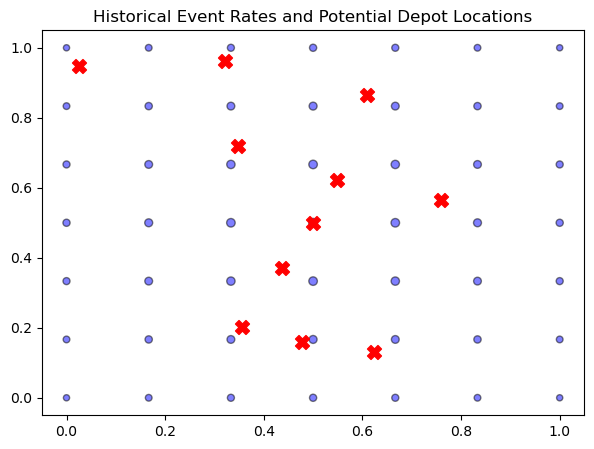

In [2]:
#create a plot of the zone_centers, where the size of each point is proportional to the event_counts
plt.figure(figsize=(7, 5))
plt.scatter(zone_centers[:, 0], zone_centers[:, 1], s=event_rates * 20, alpha=0.5, c='blue', edgecolors='k')
# Add depot locations to the plot
plt.scatter(depot_locations[:, 0], depot_locations[:, 1], s=100, c='red', marker='X', label='Depots')
plt.title('Historical Event Rates and Potential Depot Locations')
plt.show()


### Towards a formulation
We have some problem data:
 - A drone can travel the length of region (i.e. a distance of $1$) in 1 minute
 - After a lot of internal debate, Decion-makers want to open 5 drone depots.

Using this information, formulate and solve a mixed-binary, linear optimization problem to determine which depots to open

In [10]:
drone_speed = 1  #in units of length of region/minute
max_depots = 5  # maximum number of depots we can open is the number of depot locations available
 
m = Model("Emergency Response Optimization")

# DECISION VARIABLES
# binary variable to see if a depot is opened at a location
z = m.addVars(len(depot_locations), vtype=GRB.BINARY, name="x")

# x is a binary variable to see if depot i serves zone j
x = m.addVars(len(depot_locations), len(zone_centers), vtype=GRB.BINARY, name="y")

# CONSTRAINTS

# only allowed to build 5 depots
m.addConstr(quicksum(z[i] for i in range(len(depot_locations))) <= max_depots, "MaxDepots")

# each zone must be served by atleast one depot
for j in range(len(zone_centers)):
    m.addConstr(quicksum(x[i, j] for i in range(len(depot_locations))) >= 1, f"ServeZone_{j}")

for i in range(len(depot_locations)):
    for j in range(len(zone_centers)):
        m.addConstr(x[i,j] <= z[i], f"DepotOpen_{i}_{j}")  # if depot i is not open, it cannot serve zone j
        

# OBJECTIVE FUNCTION
# minimize the total distance traveled by all drones
m.setObjective(
    quicksum(distance_matrix[j, i] * event_rates[j] * x[i, j] for i in range(len(depot_locations)) for j in range(len(zone_centers))),
    GRB.MINIMIZE
)


m.optimize()

#print the set of open depots
print("Optimal depot locations:")
for i in range(len(depot_locations)):
    if z[i].X > 0.5:  # if depot i is open
        print(f"Depot at location {depot_locations[i]} serves zones:")
        for j in range(len(zone_centers)):
            if x[i, j].X > 0.5:  # if depot i serves zone j
                print(f"  Zone {j} at location {zone_centers[j]}")

#print the objective value
print(f"Total distance traveled: {m.ObjVal}")


Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[x86] - Darwin 23.5.0 23F79)

CPU model: Intel(R) Core(TM) i5-1038NG7 CPU @ 2.00GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 589 rows, 550 columns and 1628 nonzeros
Model fingerprint: 0xace2224a
Variable types: 0 continuous, 550 integer (550 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Presolve removed 1 rows and 1 columns
Presolve time: 0.01s
Presolved: 588 rows, 549 columns, 1626 nonzeros
Variable types: 0 continuous, 549 integer (549 binary)
Found heuristic solution: objective 60.7040258
Found heuristic solution: objective 51.3261248
Found heuristic solution: objective 51.2971350

Root relaxation: objective 1.537208e+01, 158 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexp

## Plot the routing plan

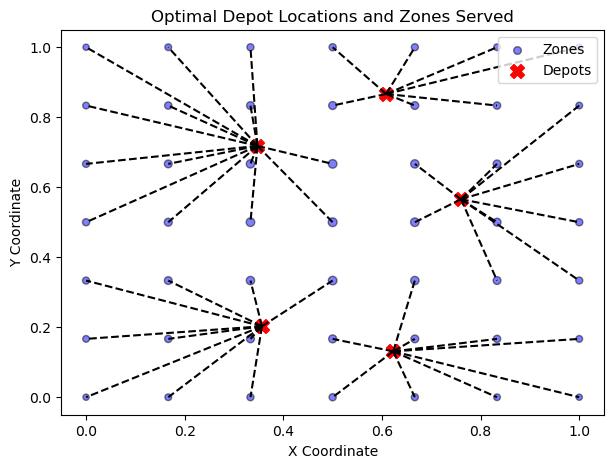

In [12]:
# Plot the optimal depot locations and the zones they serve
plt.figure(figsize=(7, 5))
plt.scatter(zone_centers[:, 0], zone_centers[:, 1], s=event_rates * 20, alpha=0.5, c='blue', edgecolors='k')
# Add depot locations to the plot
for i in range(len(depot_locations)):
    if z[i].X > 0.5:  # if depot i is open
        plt.scatter(depot_locations[i, 0], depot_locations[i, 1], s=100, c='red', marker='X')
        for j in range(len(zone_centers)):
            if x[i, j].X > 0.5:  # if depot i serves zone j
                plt.plot([depot_locations[i, 0], zone_centers[j, 0]], [depot_locations[i, 1], zone_centers[j, 1]], 'k--')
plt.title('Optimal Depot Locations and Zones Served')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(['Zones', 'Depots'])
plt.show()


### Simulating to understand the robustness of the solution

Our choice of depots depends on the estimated rate of incidents in each zone.  But these rates are estimated.  Might small errors in those estimated rates manifest as large increases in response time?  

You consult your data science friend.  They suggest that since you're not very sure about the rates, you might perturb the estimated rates by a random amount that's about 5\% of the current value.  Your friend suggest by multiplying by a random number chosen between .95 and 1.05

 Run a simulation where you perturb the rates of incidents randomly as suggested above and compute a histogram for the total response time in the system.

In [19]:
noise_frac = .05
numReps = 1000
tot_time = np.zeros(numReps)
new_lambdas = np.zeros(len(zone_centers))

# set the seed to 52
np.random.seed(52)

#multiply the event rates by a random number between 1-noise_frac and 1+noise_frac

for rep in range(numReps):
    for j in range(len(zone_centers)):
        noise = np.random.uniform(1-noise_frac, 1+noise_frac)
        new_lambdas[j] = event_rates[j] * noise
        
    for j in range(len(zone_centers)):
        for i in range(len(depot_locations)):
            tot_time[rep] += distance_matrix[j, i] * new_lambdas[j] * x[i, j].X


print(f"Average total time over {numReps} iterations: {np.mean(tot_time)}")
print(f"Standard deviation of total time over {numReps} iterations: {np.std(tot_time)}")


Average total time over 1000 iterations: 15.371425651579807
Standard deviation of total time over 1000 iterations: 0.06883233750331928


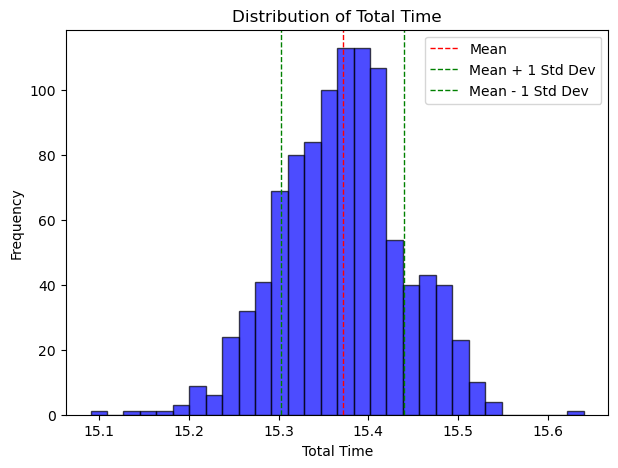

In [20]:
# plot a histogram of the total time
plt.figure(figsize=(7, 5))
plt.hist(tot_time, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Total Time')
plt.xlabel('Total Time')
plt.ylabel('Frequency')
plt.axvline(np.mean(tot_time), color='red', linestyle='dashed', linewidth=1, label='Mean')
plt.axvline(np.mean(tot_time) + np.std(tot_time), color='green', linestyle='dashed', linewidth=1, label='Mean + 1 Std Dev')
plt.axvline(np.mean(tot_time) - np.std(tot_time), color='green', linestyle='dashed', linewidth=1, label='Mean - 1 Std Dev')
plt.legend()
plt.show()

## The number of depots

The American Heart Association recommends that an AED be placed on a patient who has a cardiac incident within 5 minutes.  How many depots would you need to accomplish this?